In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

headers = ['user_id', 'movie_id', 'rating', 'time']
data = pd.read_table('ml-100k/u.data', sep='\t', header=None, names=headers)

In [32]:
data.head()

,user_id,movie_id,rating,time
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [39]:
user = data['user_id'].values
movie = data['movie_id'].values
rating = data['rating'].values

In [4]:
def build_R(user, movie, rating):
    R = np.zeros((943,1682),dtype=int)
    for i in range(len(user)):
        R[user[i]-1, movie[i]-1] = rating[i]
    return R

In [5]:
R = build_R(user, movie, rating)
W = (R!=0)
W[W == True] = 1
W[W == False] = 0
# To be consistent with our Q matrix
W = W.astype(np.float64, copy=False)
W

array([[ 1.,  1.,  1., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.]])

In [6]:
def get_error(R, U, V, W):
    return np.sum((W * (R - np.dot(U, V))**2))

In [28]:
print R.shape
R

(943, 1682)


array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]])

# Part 1 (No Cross Validation)

('min error:', 518682.62841141428)


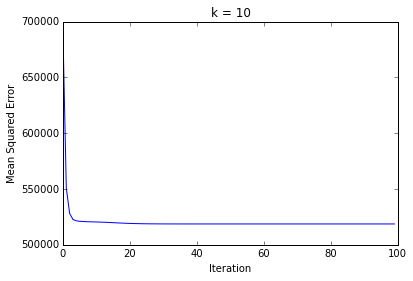

('min error:', 344321.48484513257)


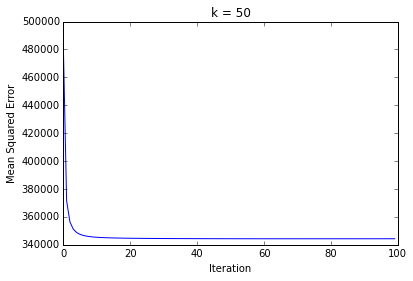

('min error:', 228771.95513621415)


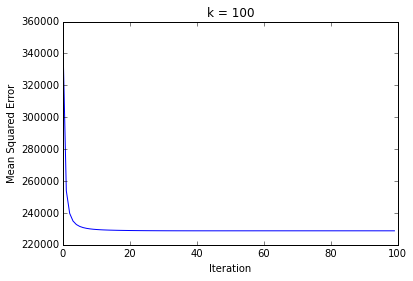

('min error:', 7328.5006101953968)


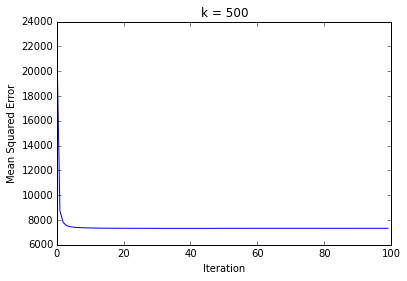

In [8]:
m, n = R.shape
n_iterations = 100
min_error = np.inf
for k in (10, 50, 100, 500):
    U = 5 * np.random.rand(m, k)
    V = 5 * np.random.rand(k, n)
    errors = []
    for it in range(n_iterations):
        U = np.linalg.solve(np.dot(V, V.T), np.dot(V, R.T)).T
        V = np.linalg.solve(np.dot(U.T, U), np.dot(U.T, R)) 
        error = get_error(R, U, V, W)                
        errors.append(error)
        
        # find the R_hat with min error
        if error<min_error:
            min_error = error
            R_hat = np.dot(U, V)

    print("min error:", min_error)
    plt.plot(errors)
    plt.title("k = %d" % k)
    plt.ylabel("Mean Squared Error")
    plt.xlabel("Iteration")
    plt.show()

In [9]:
R_hat-=np.min(R_hat)
R_hat *= float(5) / np.max(R_hat)
R_hat

array([[ 4.6685711 ,  3.09151157,  3.79704864, ...,  0.67870268,
         0.67237972,  0.70181976],
       [ 3.84779138,  0.74279844,  0.9081698 , ...,  0.65855347,
         0.70184005,  0.7114051 ],
       [ 0.70167886,  0.74914972,  0.718823  , ...,  0.72389392,
         0.71574997,  0.6606244 ],
       ..., 
       [ 4.63974204,  0.66136223,  0.67457705, ...,  0.69266462,
         0.68256109,  0.69085666],
       [ 0.70527442,  0.95854795,  0.7553875 , ...,  0.68134905,
         0.69411845,  0.67493008],
       [ 0.6581675 ,  4.55757412,  0.80506508, ...,  0.71564836,
         0.73029981,  0.67570742]])

# Part 2 (Cross Validation)

In [29]:
# from sklearn.model_selection import KFold

# def validation_error(test_user, test_movie, R, test_rating):
#     error = 0
#     for i in range(len(test_user)):
#         error += np.absolute(test_rating[i]-R[test_user[i]-1, test_movie[i]-1])
#     return error

# # 10-fold cross validation
# m, n = R.shape
# n_iterations = 100
# kf = KFold(n_splits=10)

# for k in (10, 50, 100, 500):
#     count = 1
#     v_errors = []
#     for train, test in kf.split(user):
#         train_user = user[train]
#         train_movie = movie[train]
#         train_rating = rating[train]
#         test_user = user[test]
#         test_movie = movie[test]
#         test_rating = rating[test]

#         R = build_R(train_user, train_movie, train_rating)
#         W = (R!=0)
#         W[W == True] = 1
#         W[W == False] = 0
#         W = W.astype(np.float64, copy=False)

#         U = 5 * np.random.rand(m, k) 
#         V = 5 * np.random.rand(k, n)
#         errors = []
#         min_error = np.inf
#         for it in range(n_iterations):
#             U = np.linalg.solve(np.dot(V, V.T), np.dot(V, R.T)).T
#             V = np.linalg.solve(np.dot(U.T, U), np.dot(U.T, R)) 
#             error = get_error(R, U, V, W)                
#             errors.append(error)
#             if error<min_error:
#                 min_error = error
#                 min_test = test
#                 R_hat = np.dot(U, V)

#         R_hat -= np.min(R_hat)
#         R_hat *= float(5) / np.max(R_hat)
#         v_error = validation_error(test_user, test_movie, R_hat, test_rating)
#         print("k=%d, average error of test %d:%f"%(k, count, v_error/len(test_user)))
#         v_errors.append(v_error)
#         count += 1
#     print("average error of k=%d system:%f"%(k, sum(v_errors)/10))
    

<generator object split at 0x128ff57d0>

In [ ]:
from sklearn.model_selection import KFold

def validation_error(test_user, test_movie, R, test_rating):
    error = 0
    for i in range(len(test_user)):
        error += np.absolute(test_rating[i]-R[test_user[i]-1, test_movie[i]-1])
    return error

# 10-fold cross validation
m, n = R.shape
n_iterations = 100
kf = KFold(n_splits=10, shuffle=True, random_state=50)

for k in (10, 50, 100, 500):
    count = 1
    v_errors = []
    for train_index,test_index in kf.split(data):
        train = data.as_matrix()[train_index]
        test = data.as_matrix()[test_index]
        W = (R!=0)
        W[W == True] = 1
        W[W == False] = 0
        # To be consistent with our Q matrix
        W = W.astype(np.float64, copy=False)

        for i in range(len(train_index)):
            W[train[i][0] - 1, train[i][1] - 1] = 1

        U = 5 * np.random.rand(m, k) 
        V = 5 * np.random.rand(k, n)
        errors = []
        min_error = np.inf
        for it in range(n_iterations):
            U = np.linalg.solve(np.dot(V, V.T), np.dot(V, R.T)).T
            V = np.linalg.solve(np.dot(U.T, U), np.dot(U.T, R)) 
            error = get_error(R, U, V, W)                
            errors.append(error)
            if error<min_error:
                min_error = error
                min_test = test
                R_hat = np.dot(U, V)

        R_hat -= np.min(R_hat)
        R_hat *= float(5) / np.max(R_hat)
        
        v_error = 0
        for j in range(len(test_index)):
            v_error += np.absolute(test[j][2]-R_hat[test[j][0]-1, test[j][1]-1])
        
#         v_error = validation_error(test_user, test_movie, R_hat, test_rating)
        print("k=%d, average error of test %d:%f"%(k, count, v_error/len(test_index)))
        v_errors.append(v_error)
        count += 1
        print("average error of k=%d system:%f"%(k, sum(v_errors)/10))
    
    
 

k=10, average error of test 1:1.858030
average error of k=10 system:1858.029846
k=10, average error of test 2:1.877288
average error of k=10 system:3735.317615
k=10, average error of test 3:1.852146
average error of k=10 system:5587.463955
k=10, average error of test 4:1.845032
average error of k=10 system:7432.495797
k=10, average error of test 5:1.857828
average error of k=10 system:9290.323799
k=10, average error of test 6:1.856006
average error of k=10 system:11146.329780
k=10, average error of test 7:1.850142
average error of k=10 system:12996.471931
k=10, average error of test 8:1.877411
average error of k=10 system:14873.883178
k=10, average error of test 9:1.852948
average error of k=10 system:16726.831465
k=10, average error of test 10:1.854741
average error of k=10 system:18581.572891
k=50, average error of test 1:1.420244
average error of k=50 system:1420.243582


In [75]:
data

,user_id,movie_id,rating,time
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
5,298,474,4,884182806
6,115,265,2,881171488
7,253,465,5,891628467
8,305,451,3,886324817
9,6,86,3,883603013


# Part 4

In [18]:
W_1 = R.copy()
R_1 = W.copy()

In [20]:
m, n = R_1.shape
n_iterations = 100
min_error = np.inf
lmbda = 0.1
for k in (10, 50, 100, 500):
    U = 5 * np.random.rand(m, k)
    V = 5 * np.random.rand(k, n)
    errors = []
    for it in range(n_iterations):
        U = np.linalg.solve(np.dot(V, V.T), np.dot(V, R_1.T)).T
        V = np.linalg.solve(np.dot(U.T, U), np.dot(U.T, R_1)) 
        error = get_error(R_1, U, V, W_1)                
        errors.append(error)
        
        # find the R_hat with min error
        if error<min_error:
            min_error = error
            R_hat = np.dot(U, V)

    print("min error:", min_error)
#     plt.plot(errors)
#     plt.title("k = %d" % k)
#     plt.ylabel("Mean Squared Error")
#     plt.xlabel("Iteration")
#     plt.show()

('min error:', 128477.50258650996)
('min error:', 86856.191143467178)
('min error:', 59139.928507367258)
('min error:', 2068.8359238835428)


In [22]:
m, n = R_1.shape
n_iterations = 100
min_error = np.inf
lmbda = 0.1
for k in (10, 50, 100, 500):
    U = 5 * np.random.rand(m, k)
    V = 5 * np.random.rand(k, n)
    errors = []
    for it in range(n_iterations):
        U = np.linalg.solve(np.dot(V, V.T) + lmbda * np.eye(k), np.dot(V, R_1.T)).T
        V = np.linalg.solve(np.dot(U.T, U) + lmbda * np.eye(k), np.dot(U.T, R_1)) 
        error = get_error(R_1, U, V, W_1)                
        errors.append(error)
        
        # find the R_hat with min error
        if error<min_error:
            min_error = error
            R_hat = np.dot(U, V)

    print("min error:", min_error)

('min error:', 129037.43007387281)
('min error:', 87380.972282393632)
('min error:', 59645.385795781098)
('min error:', 2219.8296832031606)


In [23]:
m, n = R_1.shape
n_iterations = 100
min_error = np.inf
lmbda = 0.01
for k in (10, 50, 100, 500):
    U = 5 * np.random.rand(m, k)
    V = 5 * np.random.rand(k, n)
    errors = []
    for it in range(n_iterations):
        U = np.linalg.solve(np.dot(V, V.T) + lmbda * np.eye(k), np.dot(V, R_1.T)).T
        V = np.linalg.solve(np.dot(U.T, U) + lmbda * np.eye(k), np.dot(U.T, R_1)) 
        error = get_error(R_1, U, V, W_1)                
        errors.append(error)
        
        # find the R_hat with min error
        if error<min_error:
            min_error = error
            R_hat = np.dot(U, V)

    print("min error:", min_error)

('min error:', 129016.50576889928)
('min error:', 87340.230121819623)
('min error:', 59533.835787389493)
('min error:', 2129.8590687931305)


In [24]:
m, n = R_1.shape
n_iterations = 100
min_error = np.inf
lmbda = 1
for k in (10, 50, 100, 500):
    U = 5 * np.random.rand(m, k)
    V = 5 * np.random.rand(k, n)
    errors = []
    for it in range(n_iterations):
        U = np.linalg.solve(np.dot(V, V.T) + lmbda * np.eye(k), np.dot(V, R_1.T)).T
        V = np.linalg.solve(np.dot(U.T, U) + lmbda * np.eye(k), np.dot(U.T, R_1)) 
        error = get_error(R_1, U, V, W_1)                
        errors.append(error)
        
        # find the R_hat with min error
        if error<min_error:
            min_error = error
            R_hat = np.dot(U, V)

    print("min error:", min_error)

('min error:', 129895.74084478374)
('min error:', 89135.495839196999)
('min error:', 62027.170955719601)
('min error:', 4461.7285549647422)
